# Basics of mobile robotics project report

### Group members:

* Raphael Linsen 322834
* Pierre-Vincent Naayem 257676
* Nathan Laroche 270509
* Yanis Bouadi 283606

### Imports used for this project

In [1]:
import cv2
import math
from math import cos, sin, degrees, radians
import numpy as np
import matplotlib.pyplot as plt
from MTM import matchTemplates, drawBoxesOnRGB
from scipy import ndimage, misc
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from myThymio import MyThymio
from myThymio.thymio_constants import THYMIO_SPEED_TO_MMS
from visuals import imshow
from utils import remove_white, remove_black, find_rectangle, sample_image      
from ipywidgets import interact, fixed
from IPython.display import clear_output
import ipywidgets as widgets

# Introduction

The goal of this project is to code a program for a Thymio robot. The objective is to go from a point A to a point B while avoiding obstacles.

First, we take one picture of the board with the obstacles, the Thymio and the final destination. We can then find the global path that the Thymio should take in order to arrive at destination while avoiding the obstacles. This is done using a visibility graph and the A* algorithm.

The Thymio lays on a black and white pattern (chosen to be a checkerboard pattern), which helps him locate itself with its ground sensors and a particler filter, along with the motor speeds feedback using odometry.

Finally, to avoid unexpected obstacles added afterward on the path, we implemented a local avoidance algorithm based on a potential field approach.

# 1. Environment identification using vision

Here we have the option to directly take a new picture using the camera

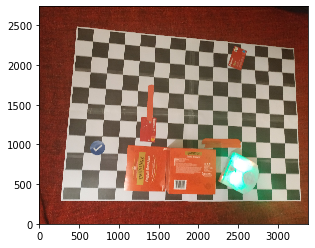

In [2]:
TAKE_NEW_PHOTO = False

img = None

if TAKE_NEW_PHOTO:
    camera = cv2.VideoCapture(0)
    while True:
        return_value, current_image = camera.read()
        gray = cv2.cvtColor(current_image,cv2.COLOR_BGR2GRAY)
        cv2.imshow('image',gray)
        if cv2.waitKey(1)& 0xFF == ord('s'):
            img = current_image[::-1,:,:]
            break
    camera.release()
    cv2.destroyAllWindows()
    
else:
    img = cv2.imread('images/terrain.jpg')[::-1,:,:]
    
imshow(img)

## Image processing for the board (Cropping and Resizing of the image)

In [3]:
# Get the vertices of the board from a thresholded image 
def find_board(threshold_val, min_white, minimum_area):
    global board
    
    #Erase white cells in order to ease the detection of the board by making the board an uniform color 
    img_no_white = remove_white(img, min_white)
    
    #Add a blur on the image to better isolate the board
    kernel_size = 101
    blurred_img = cv2.GaussianBlur(img_no_white,(kernel_size,kernel_size),0)

    #Colored threshold on the processed image to get the board with a choice between the 3 main colors (R,G,B)
    #in order to adapt to the ambiant luminosity and the color of the obstacles 
    (b, g, r) = cv2.split(blurred_img)
    _,threshold = cv2.threshold(r, threshold_val, 255,  
                                cv2.THRESH_BINARY_INV) 
    imshow(threshold)

    board = find_rectangle(threshold, minimum_area, 0.05)


interact(find_board, 
         threshold_val=widgets.IntSlider(min=0, max=255, step=3, value=75,continuous_update=False),
        min_white = widgets.IntSlider(min=0, max=255, step=3, value=120,continuous_update=False),
        minimum_area = fixed(1000000));

interactive(children=(IntSlider(value=75, continuous_update=False, description='threshold_val', max=255, step=…

Perspective transfom

In [4]:
def crop(image, rectangle):
    pts0 = np.float32(board)

    W, H = 420*2, 297*2
    # Define corresponding points in output image
    pts1 = np.float32([[0,0],[0,H],[W,H],[W,0]])

    # Get perspective transform and apply it
    M = cv2.getPerspectiveTransform(pts0,pts1)
    rescaled_img = cv2.warpPerspective(image,M,(W,H))
    return rescaled_img

rescaled_img = crop(img, board)

Plot of the resized image with only the board 

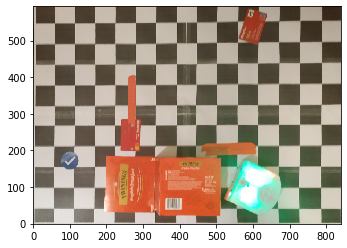

In [5]:
imshow(rescaled_img)

## Location of the thymio and the goal using pattern matching
We use pattern matching to find the goal and the initial position of the robot, in order to use it as a starting point for the particle filter.

This is the template used for the Thymio robot

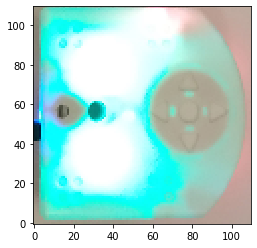

In [6]:
thymio_template = cv2.resize(cv2.imread('images/thymio.jpg')[::-1,:,:], dsize=(110, 110), interpolation=cv2.INTER_CUBIC)
imshow(thymio_template)

This is the template chosen for the final destination

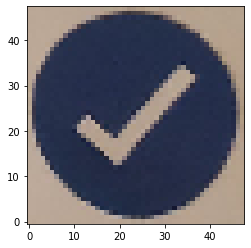

In [7]:
goal_template = cv2.resize(cv2.imread("images/destination.jpg")[::-1,:,:], dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
imshow(goal_template)

### Find a pattern on the map
This function uses the function matchTemplates() from the library MTM with various angle of rotation of the template, in order to find the direction the Thymio is facing at the beginning

In [8]:
def pattern_matching(template, image, angle_resolution = 360):
    best_angle = 0
    best = 0
    best_Hit = []
    for angle in np.arange(0, 359, angle_resolution):
        rotated = ndimage.rotate(template, angle) 
        name = "".join(["", str(angle)])
        listTemplate = [(name, rotated)]
        Hit = matchTemplates(listTemplate, image,method=cv2.TM_CCOEFF_NORMED, N_object=1,score_threshold=0.1, maxOverlap=0,searchBox=None)
        if Hit.Score.to_numpy()[0] > best:
            best_Hit = Hit
            best_angle = angle
            best = Hit.Score.to_numpy()[0]
    
    corner = best_Hit.BBox.to_numpy()[0][0:2]
    size_hit = best_Hit.BBox.to_numpy()[0][2:4]
    center = np.array(corner) + np.array(size_hit)/2
    
    angle = radians(best_angle)
    return center, angle

Find centers of the Thymio and the final destination on the map

In [9]:
#Thymio
thymio_center, thymio_angle = pattern_matching(thymio_template, rescaled_img, 2)

#Final destination
goal_center, _ = pattern_matching(goal_template, rescaled_img)

Find the center of the wheels for the Thymio

In [10]:
# Find the center of the wheels of the Thymio
theta = thymio_angle
forward = np.array([-cos(theta), sin(theta)])
wheel_center = thymio_center + forward*20

# Save the position of the thymio
thymio_pos = (wheel_center[0], wheel_center[1] , -theta)

Plot the position of the center of the Thymio wheels, his angle and the final destination on the chess board

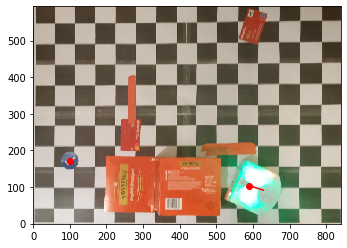

In [11]:
imshow(rescaled_img)
plt.scatter(wheel_center[0], wheel_center[1], c='r')
plt.scatter(goal_center[0], goal_center[1], c='r')
x, y = wheel_center
length = 40
plt.plot((x, x + length * math.cos(-theta)), (y, y + length * math.sin(-theta)), "r")

Plot the position of the Thymio and his wheels and the final destination on the chess board

## Obstacle map generation

In order to easily find the obstacle, we start by filtering the noise and removing the black squares from the image

In [12]:
#Add a bilateral filter to avoid noise

def remove_black_and_filter_noise(max_black):
    global filtered_img
    #Add a bilateral filter in order to ease the detection of the obstacles by limiting the noise due to black cells 
    filtered_img = cv2.bilateralFilter(rescaled_img,21, 75, 75)

    filtered_img = remove_black(filtered_img, max_black)
    kernel_size = 21
    filtered_img = cv2.GaussianBlur(filtered_img,(kernel_size,kernel_size),0)

    imshow(filtered_img)


interact(remove_black_and_filter_noise,
        max_black = widgets.IntSlider(min=0, max=255, step=3, value=130,continuous_update=False));

interactive(children=(IntSlider(value=130, continuous_update=False, description='max_black', max=255, step=3),…

We then apply a threshold to differentiate the obstacles from the ground

In [13]:
def generate_obstacle_map(threshold_val):
    global obstacle_map
    #Choose a color-based filter with a threshold such that we can isolated well
    #the obstacles despite the noise or the luminosity

    (b, g, r) = cv2.split(filtered_img)
    ret2, thresh2 = cv2.threshold(b, threshold_val, 255, cv2.THRESH_BINARY_INV)
    ret3, thresh3 = cv2.threshold(g, threshold_val, 255, cv2.THRESH_BINARY_INV)
    ret4, thresh4 = cv2.threshold(r, threshold_val, 255, cv2.THRESH_BINARY_INV)
    bgr_thresh = cv2.merge((thresh2, thresh3, thresh4))
    
    obstacle_map = thresh2
    imshow(obstacle_map)
interact(generate_obstacle_map, threshold_val=widgets.IntSlider(min=0, max=255, step=3, value=117,continuous_update=False));

interactive(children=(IntSlider(value=117, continuous_update=False, description='threshold_val', max=255, step…

# 2. Global navigation
Global navigation is done by generating the visibility graph, and applying the A* algorithm afterward to find the best path.

### Creation of the nodes
The obstacle are approximated by polygons using the approxPolyDP() from cv2. Then, for each polygon corner, 3 node are created, at a distance of 90mm of the corner.

In [14]:
#Margin around the obstacles: the chosen margin make the Thymio avoid obstacles with non regular shapes. 
MARGIN = 90

from numpy import sqrt
def norm(vec):
    return sqrt(vec[0]**2 + vec[1]**2)

def generate_way_points(arclen, min_obstacle_area, plot=False):
    global way_points
    # Detecting shapes in image by selecting region with same colors or intensity

    contours,_=cv2.findContours(obstacle_map, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

    obstacles =  []

    # Searching through every region selected to find the required polygon

    for cnt in contours : 
        area = cv2.contourArea(cnt) 

        # Shortlisting the regions based on there area 
        if area > min_obstacle_area:  
            approx = cv2.approxPolyDP(cnt,  
                                      arclen * cv2.arcLength(cnt, True), True) 
            obstacles.append(approx)
        else:
            cv2.drawContours(obstacle_map, [cnt], -1, 0, thickness=-1)

    imshow(obstacle_map)

    #Margin that we use to avoid obstacles applied to each nodes

    way_points = []

    # Find the edges or each obstacles and then put nodes in circular arc
    # at a confortable distance to avoid it and then we plot them on the 
    # processed image

    for obstacle in obstacles:
        n= len(obstacle)
        for i in range(n):
            vertice1 = obstacle[i][0]
            vertice2 = obstacle[(i+1)%n][0]
            vertice3 = obstacle[(i+2)%n][0]

            vec1 = vertice2 - vertice1
            vec1 = vec1/norm(vec1)
            
            vec2 = vertice2 - vertice3
            vec2 = vec2/norm(vec2)
            
            vec1_perp = np.array([-vec1[1], vec1[0]])
            vec2_perp = np.array([vec2[1], -vec2[0]])

            normal_vec = vec1/norm(vec1) + vec2/norm(vec2)
            normal_vec = normal_vec/norm(normal_vec)
            
            way_point1 = vertice2 + vec1_perp*MARGIN
            way_point2 = vertice2 + vec2_perp*MARGIN
            way_point3 = vertice2 + normal_vec*MARGIN
            
            way_points.append(way_point1)
            way_points.append(way_point2)
            way_points.append(way_point3)
            
            if plot:
                plt.plot((vertice1[0], vertice2[0]), (vertice1[1], vertice2[1]), 'b')
    
    # remove way_points outside the map
    way_points = [p for p in way_points if sample_image(obstacle_map, p[0], p[1]) == 0]
    if plot:
        for way_point in way_points:
            plt.scatter(way_point[0], way_point[1], c='r')
            

interact(generate_way_points, 
         arclen=widgets.FloatSlider(min=0.001, max=0.1, step=0.001, value=0.01,continuous_update=False),
         min_obstacle_area = fixed(2000),
        plot = fixed(True));

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='arclen', max=0.1, min=0.00…

## Graph generation

The first step for global navigation is to generate the visibility graph.
2 nodes will be connected during the graph generation if there is not obstacle between the two.

In [15]:
# Function that find if there is any obstacle between two consecutives nodes in order to make sure that the Thymio's path 
#does not cross an obstacle.
def noObstacleBetween(obstacle_map, p1, p2, plot=False, resolution=15):
    x, y = p1
    x_end, y_end = p2
    forward = np.array([x_end - x, y_end - y])
    
    dist = np.linalg.norm(forward)
    if dist == 0:
        return False
    
    forward = forward/dist
    perp = np.array([forward[1], -forward[0]])
    
    # We define a second margin to make sure the Thymio does not hit obstacles with non flat shapes and 
    # compensate the eventual errors due to obstacles recognition during the generation of the obstacles map.
    MARGIN2 = MARGIN*0.8
    
    #check every point in a rectangle with rounded sides region, and return false if an obstacle is found
    for perp_dist in np.arange(-MARGIN2, MARGIN2, resolution):
        for forward_dist in np.arange(-MARGIN2, dist + MARGIN2, resolution):
            if forward_dist < 0 and sqrt(perp_dist**2 + forward_dist**2) >= MARGIN2:
                continue
            if forward_dist > dist and sqrt(perp_dist**2 + (forward_dist-dist)**2) >= MARGIN2:
                continue
                
            sample_point = np.array(p1) + forward_dist*forward + perp_dist*perp
            
            if plot:
                plt.scatter(sample_point[0], sample_point[1], c='g')
                
            intensity = sample_image(obstacle_map, int(sample_point[0]), int(sample_point[1]))
            if intensity == 255:
                return False
    return True

The next figure shows the area covered during this check.

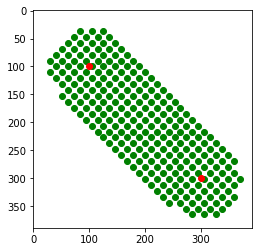

In [16]:
plt.imshow(np.zeros((100, 100)), cmap='Greys')
p1 = (100, 100)
p2 = (300, 300)
noObstacleBetween(np.zeros((600, 600)), p1, p2, plot=True)
plt.scatter([p1[0], p2[0]], [p1[1], p2[1]], c='r')

We can now use this function to connect the nodes and create the graph

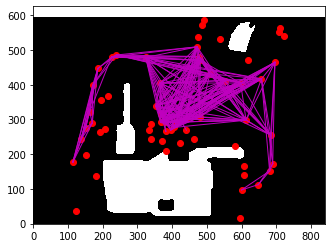

In [17]:
import itertools

# Create a class for each node

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.gScore = np.inf
        self.fScore = np.inf
        self.neighbours = []
    def plot(self, color = 'r'):
        plt.scatter(self.x, self.y, c=color)
    def get_pos(self):
        return self.x, self.y
    def __repr__(self):
        return "node ("+str(self.x)+","+str(self.y)+")"
    
#Create a clase for the graph of the map

class Graph:
    def __init__(self, way_points, obstacle_map, plot=False):
        self.obstacle_map = obstacle_map
        self.nodes = []
        for way_point in way_points:
            x, y = way_point
            self.nodes.append(Node(x, y))
        for node1, node2 in itertools.combinations(self.nodes, 2):
            if noObstacleBetween(self.obstacle_map, node1.get_pos(), node2.get_pos()):
                node1.neighbours.append(node2)
                node2.neighbours.append(node1)

                x, y = node1.get_pos()
                x_end, y_end = node2.get_pos()
                if plot:
                    plt.plot((x, x_end), (y, y_end), 'm', linewidth=1)
                
    def add_new_node(self, node):
        for potential_neighbour in self.nodes:
            if noObstacleBetween(self.obstacle_map, node.get_pos(), potential_neighbour.get_pos()):
                node.neighbours.append(potential_neighbour)
                potential_neighbour.neighbours.append(node)
        self.nodes.append(node)
    
imshow(obstacle_map)
graph = Graph(way_points, obstacle_map, plot=True)
for node in graph.nodes:
    node.plot()

## Path finding using A*

In [18]:
# Evaluate the distance 

def distance(node1, node2):
    return sqrt((node1.x-node2.x)**2 + (node1.y - node2.y)**2)

### Path computation by using a A* algorithm

def A_Star(start, goal, h):
    for node in graph.nodes:
        node.gScore = np.inf
        node.fScore = np.inf
    
    openSet = [start]
    start.gScore = 0
    closedSet = []
    
    cameFrom = dict()
    
    while openSet != []:
        current = min(openSet, key=lambda node: node.fScore)
        if current == goal:
            path = [current]
            while current in cameFrom.keys():
                path.insert(0, cameFrom[current]) 
                current=cameFrom[current]
            return path, closedSet
        
        openSet.remove(current)
        closedSet.append(current)
        
        for neighbour in current.neighbours:
            if neighbour in closedSet:
                continue
                
            tentative_gScore = current.gScore + distance(current, neighbour)
            
            if neighbour not in openSet:
                openSet.append(neighbour)
            
            if tentative_gScore < neighbour.gScore:
                cameFrom[neighbour] = current
                neighbour.gScore = tentative_gScore
                neighbour.fScore = neighbour.gScore + h(neighbour)
    print("No path found to goal")
    return None, closedSet

# this function adds the start and goal nodes, and call the A* algorithm
def compute_path(start, goal, graph, plot=False):
    start = Node(start[0], start[1])
    goal = Node(goal[0], goal[1])
    graph.add_new_node(start)
    graph.add_new_node(goal)
    
    h = lambda node: distance(node, goal)
    path_nodes, closedSet = A_Star(start, goal, h)
    
    #Convertion of the path to a list of way_points
    path = []
    for node in path_nodes:
        x, y = node.get_pos()
        path.append((x, y, 0))
    
    if plot:
        # Draw
        for node in graph.nodes:
            node.plot()
        for node in closedSet:
            node.plot('m')
        if path!=None:
            for i in range(len(path_nodes)-1):
                x, y = path_nodes[i].get_pos()
                x_end, y_end = path_nodes[i+1].get_pos()
                plt.plot((x, x_end), (y, y_end), 'g', linewidth=3)
        start.plot('g')
        goal.plot('b')
    
    return path

Call the function and plot the optimal global path

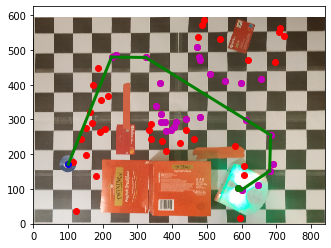

In [19]:
imshow(rescaled_img)

start = (thymio_pos[0], thymio_pos[1])
goal = (goal_center[0], goal_center[1])

path = compute_path(start, goal, graph, plot=True)

# 3. Filtering

We decided to use the particle filter algorithm in order to have a more accurate estimation of position and orientation of the Thymio and compensate for noisy or lossy data.

### Particle filter algorithm

In [20]:
# %load -n particle_filter
def particle_filter(
    particle_pos_list, speed_left_m, speed_right_m, ground_left_measure, ground_right_measure, dt
):
    weights = np.empty([NUMBER_OF_PARTICLES * NEW_GEN_NUMBER])

    new_generation = []
    i = 0
    for particle_pos in particle_pos_list:
        for _ in range(NEW_GEN_NUMBER):
            # Create the new generation using the motion uncertainty model
            speed_left = np.random.normal(speed_left_m, SIGMA_V)
            speed_right = np.random.normal(speed_right_m, SIGMA_V)
            new_pos = update_pos(particle_pos, speed_left, speed_right, dt)
            new_generation.append(new_pos)

            # Estimate the probability of the measurement if the robot was at this position, and use it as weight
            weights[i] = ground_measurement_probability(new_pos, ground_left_measure, ground_right_measure)

            i += 1

    # Sample the new generation according to the weights
    indices = range(len(new_generation))
    sample = np.random.choice(indices, size=NUMBER_OF_PARTICLES, replace=True, p=weights / np.sum(weights))

    new_particles = [new_generation[i] for i in sample]

    return new_particles

### Demonstration of the benefit of using a particle filter over odometry alone

Read the saved data from the file

In [21]:
import json
with open('saved_data.txt', 'r') as filehandle:
    (loop_path, initial_pos, saved_data) = json.load(filehandle)

Run a simulation of the algorithm using real data

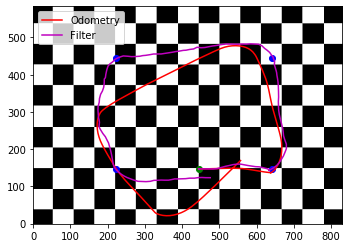

In [22]:
from utils import update_pos, NEW_GEN_NUMBER, SIGMA_V, ground_measurement_probability, get_pattern
pos_odometry = initial_pos

NUMBER_OF_PARTICLES = 70
particle_pos_list = [initial_pos for _ in range(NUMBER_OF_PARTICLES)]

odometry_pos_history = np.array((initial_pos[0], initial_pos[1]))
filter_pos_history = np.array((initial_pos[0], initial_pos[1]))
for data in saved_data:
    speed_left, speed_right, ground_left_measure, ground_right_measure, time_diff = data
    
    # Localization using only odometry
    pos_odometry = update_pos(pos_odometry, speed_left * THYMIO_SPEED_TO_MMS, speed_right * THYMIO_SPEED_TO_MMS, time_diff)
    
    # Localization using the filter
    particle_pos_list = particle_filter(
        particle_pos_list, 
        speed_left * THYMIO_SPEED_TO_MMS, speed_right * THYMIO_SPEED_TO_MMS, ground_left_measure, ground_right_measure,
        time_diff)
    pos_filter = np.mean(particle_pos_list, axis=0)
    
    # Save the results to plot afterward
    filter_pos_history = np.vstack((filter_pos_history, (pos_filter[0], pos_filter[1])))
    odometry_pos_history = np.vstack((odometry_pos_history, (pos_odometry[0], pos_odometry[1])))

# Plot the results

for point in loop_path:
    x, y, theta = point
    plt.scatter(x, y, c="b")
    
pattern = get_pattern()
plt.imshow(pattern, cmap="Greys", origin="lower")
plt.scatter(initial_pos[0], initial_pos[1], c='g')
plt.plot(odometry_pos_history[:, 0], odometry_pos_history[:, 1], 'r', label='Odometry')
plt.plot(filter_pos_history[:, 0], filter_pos_history[:, 1], 'm', label='Filter')
plt.legend()

# 4. Control

The controller returns the speed commands for the motor, given the current position the the position of the next waypoint. We use the following controller based on polar coordinates, similar to the Astolfi Controller. The result is then saturated at 45mm/s for the linear speed and 2.5 rad/s for the rotational speed.

In [23]:
# %load -n controller
def controller(current_pos, target_pos):
    x, y, theta = current_pos
    x_d, y_d, theta_d = target_pos

    x_r = x - x_d
    y_r = y - y_d
    rho = sqrt(x_r ** 2 + y_r ** 2)
    gamma = normalize_angle(atan2(y_r, x_r) - theta + pi)
    delta = normalize_angle(gamma + theta + theta_d)

    if gamma == 0:
        gamma = 0.0001

    k1 = 1.2  # affects linear speed
    k2 = 0.8  # affects rotational speed
    k3 = 0  # affects how much getting to the final angle matters

    v = k1 * rho * cos(gamma)**3
    omega = k2 * gamma + k1 * sin(gamma) * cos(gamma) / gamma * (gamma + k3 * delta)

    v = min(45, max(-45, v))
    omega = min(2.5, max(-2.5, omega))

    speed_left = (v - WHEELS_SPACING * omega / 2)
    speed_right = (v + WHEELS_SPACING * omega / 2)
    return speed_left, speed_right

# 4. Local Navigation

In part 2, we defined a global navigation using a given map. In the real life, some obstacles can appear at any time. To avoid these new obstacles, we will use local avoidance by using the sensors of the Thymio.

# 5. Run the main loop

Waiting for setup.
Completed.
Path completed.
we exit the run loop


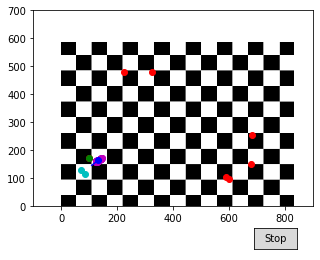

In [24]:
TIME_STEP = 0.1
myThymio = MyThymio(port="COM5", initial_pos=thymio_pos, robot_path=path, 
                    refreshing_rate=2 * TIME_STEP, 
                    compute_path_func = lambda current_pos: compute_path(current_pos, goal, graph))
myThymio.run()